In [657]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay, precision_recall_curve,roc_curve,roc_auc_score

In [658]:
df_all=pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2celltrain.csv')
features=pd.read_excel("/Users/mario/Desktop/ThesisCode/dictionary.xlsx")

# Load the holdout dataset
df_holdout = pd.read_csv('/Users/mario/Desktop/Cell2Cell Dataset/cell2cellholdout.csv')




#Merge the DataFrames
df = pd.concat([df_all, df_holdout], ignore_index=True)
df_all = df
# Lifetime Value Generation from R = Discount and Retention rate
r = 0.1 # discount rate 
Retention_Rate = 0.96 # Retention rate of Cell2Cell was 96% for the period of this dataset, the retention rate of our dataset is 72% for calibration reasons
df_all['CLV'] = df_all['MonthlyRevenue'] * df_all['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)
#df_holdout['CLV'] = df_holdout['MonthlyRevenue'] * df_holdout['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)

In [659]:
df_all['MadeCallToRetentionTeam'].value_counts()

MadeCallToRetentionTeam
No     68629
Yes     2418
Name: count, dtype: int64

In [660]:
df_all_later = df_all
df_all = df_all[df_all['MadeCallToRetentionTeam'] == 'Yes']

In [736]:
df_all_later

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,CLV
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,4,No,0,30,Yes,1-Highest,Suburban,Professional,No,11502.857143
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,5,No,0,30,No,4-Medium,Suburban,Professional,Yes,7742.585714
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes,17914.285714
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,6,No,0,10,No,4-Medium,Other,Other,No,38142.657143
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,9,No,1,10,No,1-Highest,Other,Professional,Yes,7137.585714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71042,3399938,NaN,85.15,815.0,88.0,0.00,1.0,0.4,0.0,0.0,...,0,No,0,40,No,1-Highest,Other,Other,Unknown,18063.964286
71043,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes,NaN
71044,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,No,1,Unknown,No,1-Highest,Suburban,Other,No,NaN
71045,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,No,0,150,No,3-Good,Other,Other,Unknown,NaN


In [661]:
# Sorting the DataFrame in descending order by 'CLV' and selecting rows from 9000th to 10500th observation.
df_all_later_sorted = df_all_later.sort_values(by='CLV', ascending=False)

df_holdout['CLV'] = df_holdout['MonthlyRevenue'] * df_holdout['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)
# Assuming df_holdout has been loaded and CLV has been calculated
# Calculate the 80th percentile CLV threshold to get the top 20% high-value customers
clv_threshold = df_holdout['CLV'].quantile(0.50)

# Select the top 20% of high CLV customers
subset_top_20_clv = df_holdout[df_holdout['CLV'] >= clv_threshold]

# Check the size of the subset
print(subset_top_20_clv.shape)

# Display the first few rows of the subset to verify
print(subset_top_20_clv.head())

(9972, 59)
   CustomerID  Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0     3000006    NaN           57.49           483.0                  37.0   
1     3000018    NaN           55.23           570.0                  72.0   
2     3000034    NaN           97.34          1039.0                  50.0   
3     3000070    NaN           35.59           153.0                  30.0   
4     3000074    NaN           55.27          1213.0                  50.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25            23.0           0.0              532.0   
1                   0.00             0.0           0.0               38.0   
2                   4.95           420.0           0.0              198.0   
3                   0.00            16.0           0.0               30.0   
4                   0.74             0.0           1.3              169.0   

   PercChangeRevenues  ...  IncomeGroup  OwnsMotorcycle  

### Test code for responsiveness of high value and high risk segments 

In [ ]:
# Sorting the DataFrame in descending order by 'CLV' and selecting rows from 9000th to 10500th observation.
df_all_later_sorted = df_all_later.sort_values(by='CLV', ascending=False)

df_holdout['CLV'] = df_holdout['MonthlyRevenue'] * df_holdout['MonthsInService'] * (1 + r) / (1 + r - Retention_Rate)
# Assuming df_holdout has been loaded and CLV has been calculated
# Calculate the 80th percentile CLV threshold to get the top 20% high-value customers
clv_threshold = df_holdout['CLV'].quantile(0.50)

# Select the top 20% of high CLV customers
subset_top_20_clv = df_holdout[df_holdout['CLV'] >= clv_threshold]

# Check the size of the subset
print(subset_top_20_clv.shape)

# Display the first few rows of the subset to verify
print(subset_top_20_clv.head())

In [732]:
subset = subset_top_20_clv

### Drop Service Area and CustomerID because of many unique values 

In [733]:
df_all.drop("ServiceArea",axis=1,inplace=True)
df_all.drop("CustomerID", axis=1, inplace=True)
subset.drop("ServiceArea",axis=1,inplace=True)
subset.drop("CustomerID", axis=1, inplace=True)

KeyError: "['ServiceArea'] not found in axis"

In [ ]:
def DataFrameInfo(df):
    variable_name_list=[]
    total_entry_list=[]
    data_dype_list=[]
    unique_value_list=[]
    nunique_value_list=[]
    missing_value_list=[]
    missing_value_rate_list=[]
    
    mean_list=[]
    median_list=[]
    min_list=[]
    max_list=[]
    
    for i in df.columns:
        variable_name_list.append(i)
        total_entry_list.append(df[i].count())
        data_dype_list.append(df[i].dtype)
        unique_value_list.append(list(df[i].unique()))
        nunique_value_list.append(df[i].nunique())
        missing_value_list.append(df[i].isnull().sum())
        missing_value_rate_list.append(np.round((100*df[i].isnull().sum())/(df[i].shape[0]),4))
        
        if df[i].dtype in ["float64","int64"]:
            mean_list.append(np.round(df[i].mean(),2))
            median_list.append(np.round(df[i].median(),2))
            min_list.append(df[i].min())
            max_list.append(df[i].max())
        else:
            mean_list.append(np.NaN)
            median_list.append(np.NaN)
            min_list.append(np.NaN)
            max_list.append(np.NaN)
            
        
        
        df_info_data=pd.DataFrame({"Variable_Name":variable_name_list,
                               "Type":data_dype_list,
                               "Total_Entry":total_entry_list,
                               "Missing_Value":missing_value_list,
                               "Missing_Value_Rate":missing_value_rate_list,
                               "Unique_Values":unique_value_list,
                               "Nunique_Values":nunique_value_list,
                               "Mean":mean_list,
                               "Median":median_list,
                               "Min":min_list,
                               "Max":max_list})

    return df_info_data

In [ ]:
df_info=DataFrameInfo(df_all)

In [ ]:
# Load excel file dictionary created with type of each variable for mapping
df_detail=pd.read_excel("dictionary.xlsx")
df_detail=df_detail.iloc[:,-1]

#Add the Variable Type as a new collumn to the DF Info
df_info=pd.concat([df_info,df_detail],axis=1)

In [ ]:
# Create a copy of df_info to sort descending by Missing Value
df_info_copy=df_info.copy()
df_info_copy.index=df_info["Variable_Name"]
df_info_copy.sort_values("Missing_Value",ascending=False,inplace=True)

# Plot the missing values and the Rate 
cm = sns.light_palette("red", as_cmap=True)
df_info_missing_value = df_info_copy[["Missing_Value_Rate","Missing_Value"]].style.background_gradient(cmap=cm)
df_info_missing_value

,Missing_Value_Rate,Missing_Value
Variable_Name,,
Churn,27.832900,673.000000
PercChangeMinutes,5.541800,134.000000
PercChangeRevenues,5.541800,134.000000
AgeHH2,1.447500,35.000000
AgeHH1,1.447500,35.000000
OverageMinutes,0.579000,14.000000
MonthlyRevenue,0.579000,14.000000
RoamingCalls,0.579000,14.000000
MonthlyMinutes,0.579000,14.000000


### for churn we make 3rd option Unknown. 

In [ ]:
# Convert missing values in 'Churn' column to 'Unknown'
df_all['Churn'] = df_all['Churn'].replace(np.nan, 'Unknown')
subset['Churn'] = subset['Churn'].replace(np.nan, 'Unknown')

# Ensure 'Churn' has three categories now: 'Yes', 'No', and 'Unknown'
df_all['Churn'] = df_all['Churn'].astype('category')
subset['Churn'] = subset['Churn'].astype('category')

In [ ]:
from sklearn.impute import KNNImputer
import numpy as np

# Replace 'Unknown' in columns like 'HandsetPrice' with NaN to prepare for imputation
df_all["HandsetPrice"] = df_all["HandsetPrice"].replace('Unknown', np.nan)
subset["HandsetPrice"] = subset["HandsetPrice"].replace('Unknown', np.nan)


# Select the columns to apply imputation (excluding categorical ones)
columns_to_impute = ['RoamingCalls', 'PercChangeRevenues', 'PercChangeMinutes', 'MonthlyRevenue', 'CLV', 'OverageMinutes', 'DirectorAssistedCalls', 'MonthlyMinutes', 'TotalRecurringCharge', 'HandsetPrice', 'AgeHH1', 'AgeHH2']

# Initialize the imputer
imputer = KNNImputer()

# Apply imputation to selected columns
df_all[columns_to_impute] = imputer.fit_transform(df_all[columns_to_impute])
subset[columns_to_impute] = imputer.fit_transform(subset[columns_to_impute])

In [ ]:
# Create the response rate column
df_all['response_rate'] = df_all['RetentionOffersAccepted'] / df_all['RetentionCalls']

# Handle any divisions by zero or missing values
df_all['response_rate'].fillna(0, inplace=True)  # If no calls were made, set response rate to 0


In [ ]:
# Define a threshold for classifying as positive response
response_threshold = 0.5  # You can adjust this based on your business needs

# Create the binary target variable
df_all['positive_response'] = df_all['response_rate'] >= response_threshold
subset['positive_response'] = None
df_all = df_all.drop("response_rate", axis=1)


In [ ]:
df_all.shape

(2418, 58)

In [ ]:
subset.shape

(9972, 58)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
df_all = df_all.drop("RetentionOffersAccepted", axis=1)
#subset = subset.drop("RetentionOffersAccepted", axis=1)

# Define features and target
X = df_all.drop("positive_response", axis=1)
y = df_all['positive_response']

X = pd.get_dummies(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred_rf = model.predict(X_test)

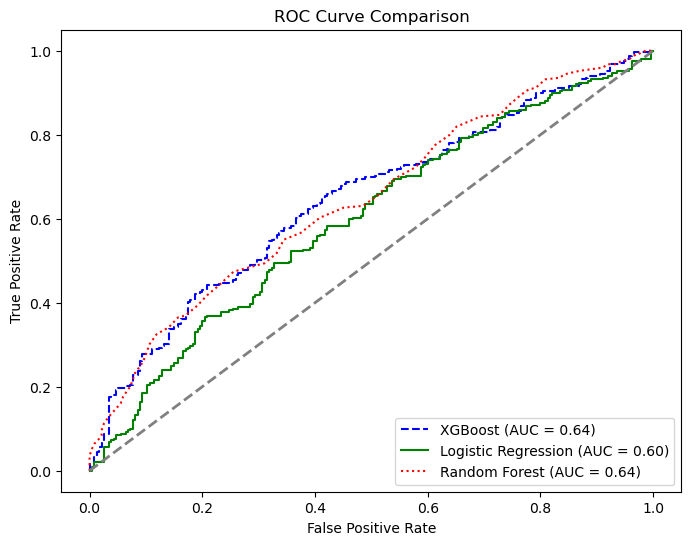

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize models
model_xgb = XGBClassifier()
model_log = LogisticRegression()
model_rf = RandomForestClassifier()

# Fit the models
model_xgb.fit(X_train, y_train)
model_log.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

# Predict probabilities for ROC AUC
y_pred_xgb_proba = model_xgb.predict_proba(X_test)[:,1]
y_pred_log_proba = model_log.predict_proba(X_test)[:,1]
y_pred_rf_proba = model_rf.predict_proba(X_test)[:,1]

# Compute ROC curves
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_proba)
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)

# Compute AUC scores
auc_xgb = roc_auc_score(y_test, y_pred_xgb_proba)
auc_log = roc_auc_score(y_test, y_pred_log_proba)
auc_rf = roc_auc_score(y_test, y_pred_rf_proba)

# Plotting the ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})', linestyle='--', color='blue')
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})', linestyle='-', color='green')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle=':', color='red')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")

# Display the plot
plt.show()

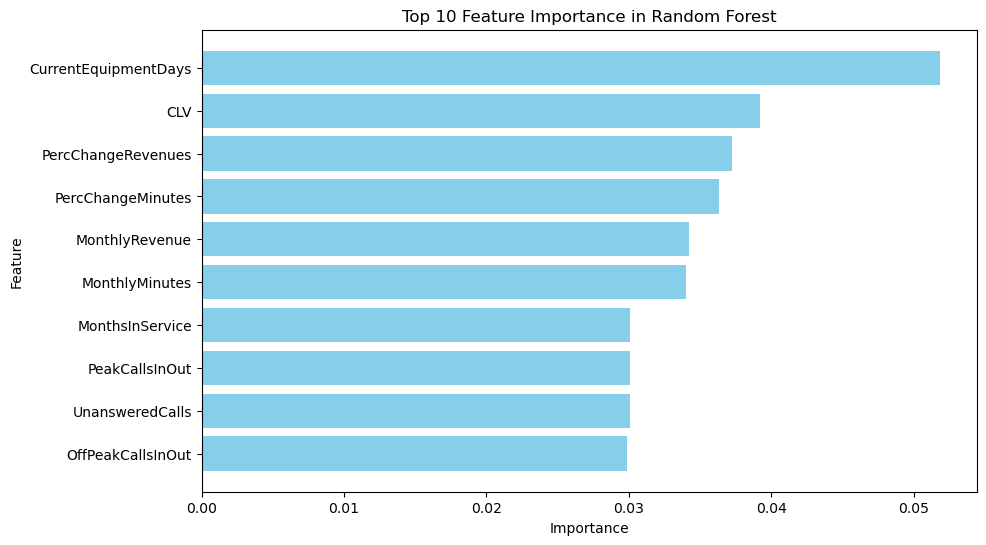

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the model
importances = model.feature_importances_

# Create a DataFrame to hold the feature names and their importance values
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select the top 10 most important features
top_10_features = feature_importances.head(10)

# Plot the top 10 feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [735]:
subset.shape

(9972, 58)

In [ ]:
subset_copy = subset.copy()


In [ ]:
subset_copy.shape

(9972, 58)

In [ ]:
# Drop 'RetentionOffersAccepted' from the subset before encoding
subset = subset.drop("RetentionOffersAccepted", axis=1)

# One-hot encode the subset DataFrame to match the features in X_train
subset_encoded = pd.get_dummies(subset)

# Align the columns of subset_encoded with X_train (fill missing columns with 0)
subset_encoded = subset_encoded.reindex(columns=X_train.columns, fill_value=0)

# Use the trained model to predict the probability of 'positive_response' for the subset
subset_copy['positive_response_proba'] = model.predict_proba(subset_encoded)[:, 1]  # Get probability of the positive class (1)

# Add the 'RetentionOffersAccepted' column back from the original subset_copy (not from subset)
subset['RetentionOffersAccepted'] = subset_copy['RetentionOffersAccepted']

# Optional: Check the first few predictions along with the 'RetentionOffersAccepted' column
print(subset_copy[['positive_response_proba', 'RetentionOffersAccepted']].tail(50))

       positive_response_proba  RetentionOffersAccepted
19911                     0.32                        0
19913                     0.68                        0
19914                     0.41                        0
19916                     0.15                        0
19917                     0.35                        0
19918                     0.52                        0
19919                     0.37                        0
19920                     0.38                        0
19921                     0.36                        0
19922                     0.45                        0
19923                     0.35                        0
19924                     0.23                        0
19925                     0.41                        0
19926                     0.64                        0
19927                     0.32                        0
19928                     0.32                        0
19932                     0.60                  

In [ ]:
subset_copy['positive_response_proba'].value_counts()

positive_response_proba
0.49    323
0.50    310
0.48    308
0.47    302
0.42    298
       ... 
0.94      2
0.08      2
0.97      1
0.06      1
0.96      1
Name: count, Length: 90, dtype: int64

In [ ]:
subset2 = subset_copy[subset_copy['MadeCallToRetentionTeam'] == "Yes"]

In [ ]:
subset2['RetentionOffersAccepted'].value_counts()

RetentionOffersAccepted
0    219
1    209
2     13
3      2
4      1
Name: count, dtype: int64

### results from the predictions align with the average acceptance rate, deviates by 2%, but the observations are too few.

In [ ]:
# Assuming 'subset2' is a DataFrame, we will select only the 'positive_response' and 'RetentionOffersAccepted' columns.
subset3 = subset2[['positive_response_proba', 'RetentionOffersAccepted', 'RetentionCalls']]


In [ ]:
subset3.head(50)

,positive_response_proba,RetentionOffersAccepted,RetentionCalls
5,0.17,0,1
7,0.89,1,1
134,0.85,1,1
149,0.84,1,1
161,0.85,1,1
185,0.63,1,1
223,0.86,1,1
227,0.68,0,1
266,0.60,1,1
291,0.58,1,2


In [ ]:
# Step 1: Sort the entire dataset by CLV in descending order
subset_sorted_by_clv = subset_copy.sort_values(by='CLV', ascending=False)

# Step 2: Select the top 2000 customers based on CLV
top_2000_clv = subset_sorted_by_clv.head(2000)

# Step 3: Within these top 2000 customers, sort by 'positive_response_proba' in descending order
intersect_segment = top_2000_clv.sort_values(by='positive_response_proba', ascending=False)

# Optional: Check the intersect segment
print(intersect_segment[['CLV', 'positive_response_proba']].head(10))

# You can now analyze the intersect segment, which has the top 2000 high CLV customers sorted by their likelihood to respond positively.

               CLV  positive_response_proba
7875  22711.857143                     0.93
2272  27026.685714                     0.93
577   35885.771429                     0.93
500   50593.714286                     0.92
2319  18440.478571                     0.92
6834  29180.957143                     0.90
6256  22570.350000                     0.90
651   27086.400000                     0.90
4443  27871.328571                     0.90
8089  17479.314286                     0.89


In [ ]:
# Sort the customers by 'positive_response' (responsiveness) first and then by 'CLV'
sorted_subset = subset_copy.sort_values(by=['positive_response_proba', 'CLV'], ascending=[False, False])

# Select the top 2000 rows for the intersect segment
intersect_segment = sorted_subset.head(2000)

# Calculate the average CLV for this new intersect segment
average_clv_intersect = intersect_segment['CLV'].mean()

# Calculate the average responsiveness for this new intersect segment
average_responsiveness_intersect = intersect_segment['positive_response_proba'].mean()

# Print the average CLV and responsiveness
print(f"Average CLV of the new intersect segment: {average_clv_intersect}")
print(f"Average responsiveness of the new intersect segment: {average_responsiveness_intersect:.2%}")

Average CLV of the new intersect segment: 16623.729964285703
Average responsiveness of the new intersect segment: 66.87%


In [ ]:
intersect_segment

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,CLV,positive_response,positive_response_proba
7875,Unknown,144.53,1596.0,64.0,5.20,314.0,0.0,384.0,48.9,1.3,...,0,130.0,Yes,3-Good,Suburban,Other,Unknown,22711.857143,None,0.93
2272,Unknown,110.96,983.0,50.0,6.93,160.0,0.0,255.0,85.5,3.7,...,0,10.0,Yes,1-Highest,Other,Other,No,27026.685714,None,0.93
577,Unknown,123.44,1602.0,75.0,9.65,127.0,5.6,199.0,-1.3,27.0,...,0,80.0,Yes,3-Good,Suburban,Other,Unknown,35885.771429,None,0.93
500,Unknown,160.98,1938.0,75.0,3.96,166.0,0.0,705.0,63.9,51.3,...,0,80.0,Yes,1-Highest,Other,Self,No,50593.714286,None,0.92
2319,Unknown,80.93,630.0,50.0,2.97,83.0,3.1,-2.0,-2.3,6.3,...,1,30.0,Yes,1-Highest,Suburban,Professional,Yes,18440.478571,None,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,Unknown,102.79,634.0,50.0,0.00,176.0,0.0,-302.0,-52.8,1.3,...,0,30.0,Yes,3-Good,Other,Other,Unknown,29882.521429,None,0.15
4679,Unknown,154.07,707.0,88.0,1.24,214.0,0.0,-519.0,-53.1,2.7,...,0,60.0,Yes,2-High,Town,Professional,Unknown,32684.850000,None,0.14
1577,Unknown,80.84,790.0,40.0,2.72,1.0,0.2,-116.0,-40.9,10.0,...,0,30.0,Yes,1-Highest,Other,Other,Unknown,21595.828571,None,0.13
7452,Unknown,139.85,874.0,45.0,3.71,237.0,0.0,-314.0,-41.2,11.3,...,0,46.0,Yes,4-Medium,Other,Other,Unknown,25272.892857,None,0.12


In [ ]:
# Calculate the average CLV for the intersect segment
average_clv_intersect = intersect_segment['CLV'].mean()

# Print the average CLV
print(f"Average CLV of the intersect segment: {average_clv_intersect}")

Average CLV of the intersect segment: 16623.729964285703


In [ ]:
# Calculate the average CLV for the intersect segment
average_clv_intersect = intersect_segment['positive_response_proba'].mean()

# Print the average CLV
print(f"Average CLV of the intersect segment: {average_clv_intersect}")

Average CLV of the intersect segment: 0.66874


In [ ]:
intersect_segment

,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,...,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,CLV,positive_response,positive_response_proba
1853,Unknown,35.36,76.0,15.0,1.24,13.0,0.0,-40.0,-14.1,0.7,...,0,130.0,Yes,3-Good,Other,Other,Unknown,8057.028571,None,0.97
7867,Unknown,59.36,276.0,50.0,0.00,0.0,0.6,-11.0,-9.4,0.7,...,0,60.0,Yes,3-Good,Other,Other,No,8395.200000,None,0.96
1616,Unknown,32.99,327.0,25.0,0.00,14.0,2.0,58.0,-4.2,10.3,...,0,150.0,Yes,1-Highest,Other,Other,Yes,9331.457143,None,0.94
16705,Unknown,88.14,826.0,45.0,0.99,224.0,0.0,804.0,145.1,9.7,...,0,100.0,Yes,3-Good,Other,Other,No,9002.871429,None,0.94
577,Unknown,123.44,1602.0,75.0,9.65,127.0,5.6,199.0,-1.3,27.0,...,0,80.0,Yes,3-Good,Suburban,Other,Unknown,35885.771429,None,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,Unknown,54.12,546.0,45.0,2.23,48.0,0.1,-160.0,-18.1,15.7,...,0,30.0,No,1-Highest,Suburban,Other,Yes,14883.000000,None,0.59
1103,Unknown,51.91,706.0,41.0,0.25,49.0,0.0,126.0,-13.9,14.3,...,0,150.0,No,1-Highest,Other,Professional,Yes,14683.114286,None,0.59
3850,Unknown,81.25,701.0,90.0,0.50,0.0,0.0,-257.0,-0.3,4.0,...,0,60.0,No,2-High,Other,Other,No,14683.035714,None,0.59
3060,Unknown,66.56,295.0,55.0,4.46,48.0,0.3,224.0,54.2,11.3,...,0,30.0,No,1-Highest,Other,Professional,Yes,14643.200000,None,0.59


In [ ]:
# Load the CSV file back into a DataFrame
df_val_standart = pd.read_csv("df_val_standart.csv")


In [ ]:
# Define a tolerance (e.g., 100)
tolerance = 98

# Perform a cross join between both DataFrames and filter for close matches
merged_df = pd.merge(intersect_segment[['CLV']], df_val_standart[['OriginalCLV', 'Churn_Probability']], how='cross')

# Filter rows where the absolute difference between CLV and OriginalCLV is within the tolerance
merged_df = merged_df[abs(merged_df['CLV'] - merged_df['OriginalCLV']) <= tolerance]

# Drop duplicates to avoid multiple matches (if necessary)
merged_df = merged_df.drop_duplicates(subset=['CLV'])

# Check if the merge was successful
print(merged_df[['CLV', 'OriginalCLV', 'Churn_Probability']].head())

                CLV   OriginalCLV  Churn_Probability
155     8057.028571   8120.529223           0.638126
20033   8395.200000   8481.971003           0.634047
40193   9331.457143   9264.427702           0.430473
59772   9002.871429   9058.080158           0.656803
79663  35885.771429  35796.059564           0.353207


In [ ]:
# Calculate the average churn probability for the intersect segment
average_churn_probability = merged_df['Churn_Probability'].mean()

# Print the average churn probability for the intersect segment
print(f"Average churn probability for the intersect segment: {average_churn_probability:.2%}")

Average churn probability for the intersect segment: 53.51%


In [ ]:
overall_churn_rate = df_val_standart['Churn_Probability'].mean()
lift = average_churn_probability / overall_churn_rate
print(f"Lift of the intersect segment: {lift:.2f}")

Lift of the intersect segment: 1.07
